In [63]:
# Comparing the analytic GLRT for the single-coefficient case with the optimization-based version
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [10]:
from uncertainty.DataGeneration import linearRegression_normal
from uncertainty.torch_linear import TorchLinear
from uncertainty.analyticLinearRegressionCIs import analyticLinearTest_GLRT_singleCoef, analyticLinearCis
from uncertainty.glrtTorch import glrtTorchCis
from uncertainty.torch_linear import TorchLinear

In [77]:
def compareAnalyticVsOptimization(beta, n=200, alpha=0.05):
    """Generate data according to a linear regression with a single coefficient beta.
    Compute the analytic chi-squared test 'is the coefficient zero?'. Record the p-value.
    Compute the confidence intervals on beta using the GLRT-based method. Record whether the interval contains zero.
    Return TRUE if both methods agree, and FALSE otherwise."""  
    # Get data
    X, y = linearRegression_normal(beta=np.array([beta]), cov=np.array([[1]]), sigma=1, n=n)

    # Compute the p-value from the chi squared test
    TL = TorchLinear(lr=0.3,max_iter=30)
    TL.fit(X,y)
    pVal_TL = analyticLinearTest_GLRT_singleCoef(TL, X, y)
    
    # Next, get the optimization-based intervals.
    # GLRT method with Torch model (coefs)
    lcb_GLRT, ucb_GLRT, lcb_Results, ucb_Results, lcb_Torch, ucb_Torch = glrtTorchCis(
        lambda:TorchLinear(lr=0.3,max_iter=100), X=X, y=y, citype='coefs', alpha=alpha,
        search_kwargs={'lmbds':np.logspace(-10,10,101)},fit_kwargs={'lr':0.3,'max_iter':30})
    
    # To check whether they agree with the analytic version:
    # The p-value should be < 0.05 iff the level-0.05 glrt-based confidence interval
    # on the coefficient beta doesn't contain zero.
    isNotZero_analytic = pVal_TL < alpha    # The chi-square test is one-sided
    isNotZero_optim = (lcb_GLRT > 0) or (ucb_GLRT < 0)
    
    print("p value", pVal_TL, "and confidence interval", lcb_GLRT, "to", ucb_GLRT)
    
    return (isNotZero_analytic == isNotZero_optim, pVal_TL, lcb_GLRT[0], ucb_GLRT[0])
    

In [79]:
beta = 0.1

success = []
pVals = []
lcbs = []
ucbs = []

for i in range(10):
    s, p, l, u = compareAnalyticVsOptimization(beta=beta)
    success.append(s[0])
    pVals.append(p)
    lcbs.append(l)
    ucbs.append(u)

p value 0.6110492793835245 and confidence interval [-0.36845151] to [0.28528363]
p value 0.6869394095496293 and confidence interval [-0.41996658] to [0.47531152]
p value 0.7840765068415507 and confidence interval [-0.29657814] to [0.33596537]
p value 0.9799698330287191 and confidence interval [-0.35465574] to [0.34863517]
p value 0.943473670819427 and confidence interval [-0.35204083] to [0.32909369]
p value 0.45858562974993466 and confidence interval [-0.33594039] to [0.24440666]
p value 0.5961063637431105 and confidence interval [-0.40251437] to [0.3215296]
p value 0.3758111077430031 and confidence interval [-0.28964981] to [0.42799509]
p value 0.388976219865239 and confidence interval [-0.35489127] to [0.47153434]
p value 0.3587727687031228 and confidence interval [-0.40345594] to [0.25848916]


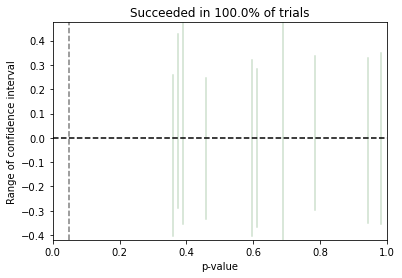

In [118]:
minY = min(lcbs)
maxY = max(ucbs)
plt.ylim(minY, maxY)

for (p, l, u, s) in zip(pVals, lcbs, ucbs, success):
    # ymin and ymax are the 'fraction of the way up from the bottom of the plot'
    plt.axvline(x=p, ymin=(l-minY)/(maxY - minY), ymax=(u-minY)/(maxY-minY),
                color=('darkgreen' if success else 'darkred'), alpha=0.2)

# plt.scatter(np.asarray(pVals)[np.array(success)], np.asarray(lcbs)[np.array(success)], color='darkgreen')
# plt.scatter(np.asarray(pVals)[np.array(success)], np.asarray(ucbs)[np.array(success)], color='darkgreen')

# plt.scatter(np.asarray(pVals)[~np.array(success)], np.asarray(lcbs)[~np.array(success)], color='darkred', marker='x')
# plt.scatter(np.asarray(pVals)[~np.array(success)], np.asarray(ucbs)[~np.array(success)], color='darkred', marker='x')

plt.axhline(0, color='k', linestyle='--')
plt.axvline(0.05, color='gray', linestyle='--')

plt.xlabel("p-value")
plt.ylabel("Range of confidence interval")
plt.title("Succeeded in " + str(np.mean(success)*100) + "% of trials")

plt.show()